# Step 1: Data Preprocessing

In [3]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Load data
users_df = pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')
engagement_df = pd.read_csv('takehome_user_engagement.csv')

# Convert timestamp columns to datetime
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

# Display initial data
print(users_df.head())
print(engagement_df.head())


   object_id       creation_time               name  \
0          1 2014-04-22 03:53:30     Clausen August   
1          2 2013-11-15 03:45:04      Poole Matthew   
2          3 2013-03-19 23:14:52  Bottrill Mitchell   
3          4 2013-05-21 08:09:28    Clausen Nicklas   
4          5 2013-01-17 10:14:20          Raw Grace   

                        email creation_source last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE        2014-04-22 03:53:30   
1      MatthewPoole@gustr.com      ORG_INVITE        2014-03-31 03:45:04   
2  MitchellBottrill@gustr.com      ORG_INVITE        2013-03-19 23:14:52   
3   NicklasSClausen@yahoo.com    GUEST_INVITE        2013-05-22 08:09:28   
4          GraceRaw@yahoo.com    GUEST_INVITE        2013-01-22 10:14:20   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11   
1                         0                           0       1   
2          

# Step 2: Define Adopted Users

In [7]:
# Sort engagement data by user_id and time_stamp
engagement_df = engagement_df.sort_values(by=['user_id', 'time_stamp'])

# Identify adopted users
adopted_users = set()

# Loop through each user's login dates and check for three logins in a seven-day period
for user_id, group in engagement_df.groupby('user_id'):
    login_dates = group['time_stamp'].sort_values()
    # Calculate the difference between logins in terms of days
    for i in range(len(login_dates) - 2):
        if (login_dates.iloc[i + 2] - login_dates.iloc[i]).days <= 7:
            adopted_users.add(user_id)
            break

# Add adopted user column in users_df
users_df['adopted_user'] = users_df['object_id'].apply(lambda x: 1 if x in adopted_users else 0)

# Check distribution
print(users_df['adopted_user'].value_counts())



adopted_user
0    10344
1     1656
Name: count, dtype: int64


# Step 3: Exploratory Data Analysis (EDA)

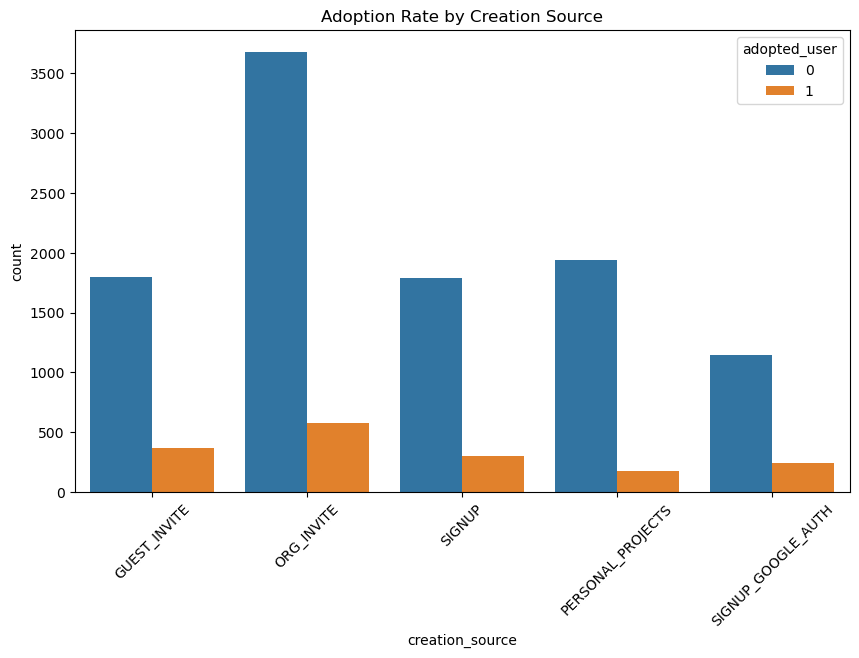

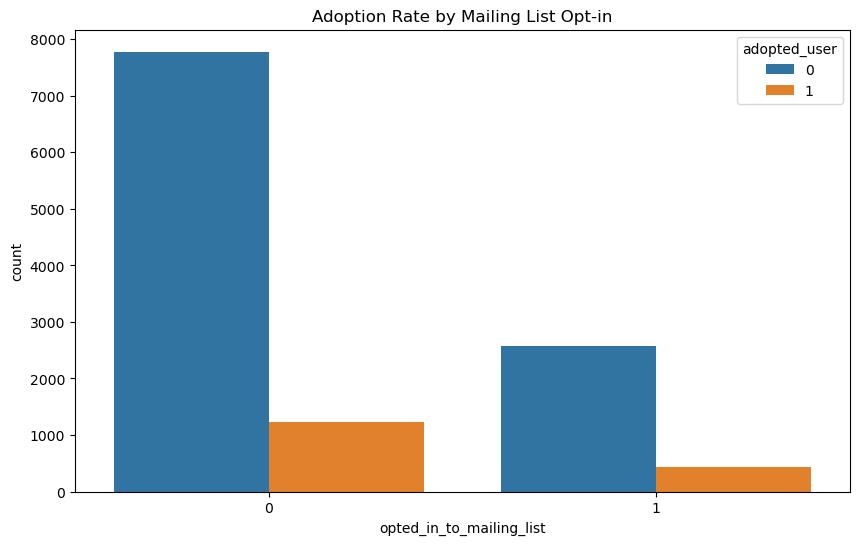

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of adopted users by creation source
plt.figure(figsize=(10, 6))
sns.countplot(data=users_df, x='creation_source', hue='adopted_user')
plt.title('Adoption Rate by Creation Source')
plt.xticks(rotation=45)
plt.show()

# Adoption rate by opting into mailing list
plt.figure(figsize=(10, 6))
sns.countplot(data=users_df, x='opted_in_to_mailing_list', hue='adopted_user')
plt.title('Adoption Rate by Mailing List Opt-in')
plt.show()

# Other feature explorations can follow a similar pattern


# Step 4: Predictive Modeling

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

# Encode categorical features
users_df['creation_source'] = LabelEncoder().fit_transform(users_df['creation_source'])

# Select features and target
X = users_df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id']]
y = users_df['adopted_user']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      1.00      0.93      3100
           1       0.00      0.00      0.00       500

    accuracy                           0.86      3600
   macro avg       0.43      0.50      0.46      3600
weighted avg       0.74      0.86      0.80      3600



/home/datascience/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/datascience/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/datascience/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

# STEP 5: Trying solving class imbalance

In [10]:
from imblearn.over_sampling import SMOTE

# Resample training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the model with resampled data
model.fit(X_resampled, y_resampled)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Set threshold for adopted user prediction
threshold = 0.3
y_pred_adjusted = (y_probs >= threshold).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

           0       0.89      0.09      0.16      3100
           1       0.14      0.93      0.25       500

    accuracy                           0.20      3600
   macro avg       0.51      0.51      0.20      3600
weighted avg       0.78      0.20      0.17      3600



# STEP 6: Adding New Features

In [11]:
# Calculate additional features for each user
engagement_df['login_count'] = engagement_df.groupby('user_id')['time_stamp'].transform('count')
engagement_df['avg_days_between_logins'] = engagement_df.groupby('user_id')['time_stamp'].diff().dt.days.mean()

# Merge new features back into the users dataset
user_features = engagement_df.groupby('user_id').agg(
    total_logins=('login_count', 'sum'),
    avg_days_between_logins=('avg_days_between_logins', 'mean')
).reset_index()

users_df = users_df.merge(user_features, left_on='object_id', right_on='user_id', how='left').fillna(0)


In [12]:
from sklearn.ensemble import RandomForestClassifier

# Prepare features and target variable
X = users_df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'total_logins', 'avg_days_between_logins']]
y = users_df['adopted_user']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3100
           1       0.91      0.98      0.94       500

    accuracy                           0.98      3600
   macro avg       0.95      0.98      0.97      3600
weighted avg       0.98      0.98      0.98      3600



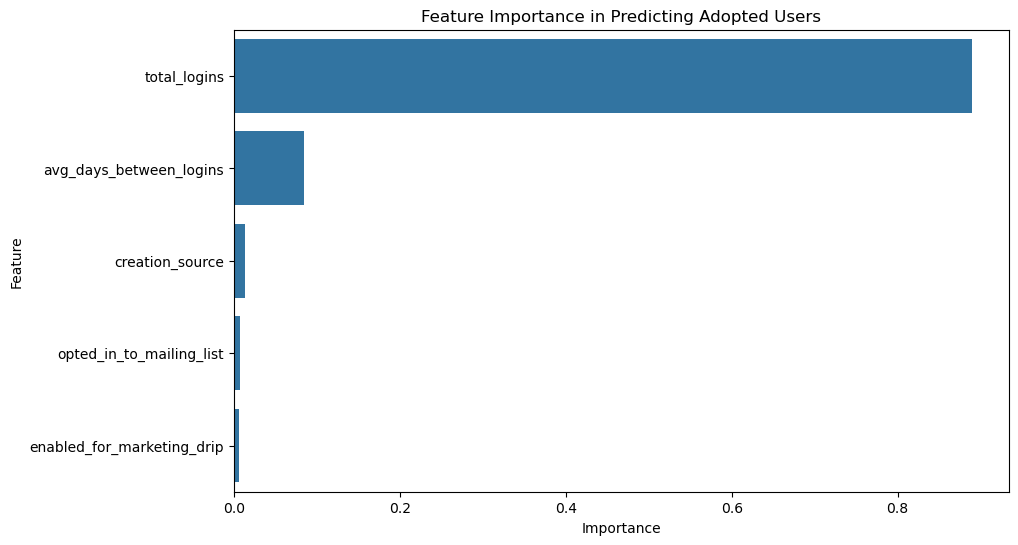

In [13]:
# Get feature importances
feature_importances = rf_model.feature_importances_
features = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance in Predicting Adopted Users')
plt.show()
